In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [25]:
#reading data
df_train = pd.read_csv('./housepricing/train.csv')
df_test = pd.read_csv('./housepricing/test.csv')

In [26]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

In [28]:
#missing test data
totat_test = df_test.isnull().sum().sort_values(ascending=False)
percent_test = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([totat_test, percent_test], axis=1, keys=['Total', 'Percent'])
#dealing with missing data
df_test = df_test.drop((missing_data_test[missing_data_test['Total'] > 1]).index,1)
df_test = df_test.drop(df_test.loc[df_test['Electrical'].isnull()].index)
df_test.isnull().sum().max() #just checking that there's no missing data missing...

1

In [29]:
#outliers
#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

In [30]:
#normalization

#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])
#data transformation
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

#transform data
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

In [31]:
#convert categorical variable into dummy, numbers who was stupid enough to call it get dummies
df_train = pd.get_dummies(df_train)

In [32]:
def_test = pd.get_dummies(df_test)

In [41]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, df_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [42]:
model_ridge = Ridge()

In [43]:
y = df_train.SalePrice

In [44]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

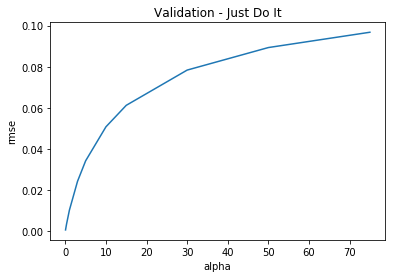

In [45]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [48]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(df_train, y)

In [49]:
rmse_cv(model_lasso).mean()


0.0035391875582831897

In [51]:
coef = pd.Series(model_lasso.coef_, index = df_train.columns)

In [52]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 21 variables and eliminated the other 201 variables


In [53]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,'Coefficients in the Lasso Model')

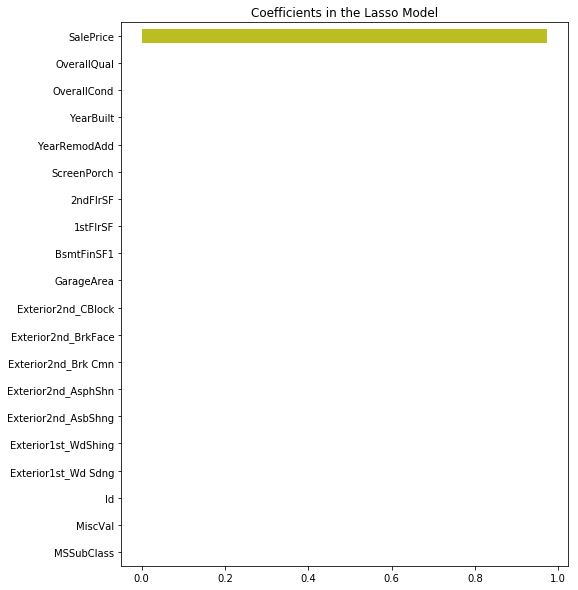

In [55]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")